## Projekt o rozdzielaniu na klastry

### Cele projektu:

* zidentyfikować korelacje między zmiennymi i spojrzeć na macierz korelacji
* rozdzielić dane na klastry
* zastosować RandomForestClassifier aby przewidzieć kto będzie miał raka, a kto nie

In [358]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import skew
from scipy.cluster.hierarchy import dendrogram, linkage
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

Wgrywamy dane

In [326]:
#Wgrywamy dane
df=pd.read_csv('./breast-cancer.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


W kolumnie diagnosis mamy zmienne dwóch typów M-czyli komórki rakowe i B-komórki nie rakowe. I właśnie na tej kolumnie będę się skupiała,żeby przewidzieć czy dane będą wskazywały na M,czyli kobieta ma raka i B, gdzy raka nie ma.

Sprawdzamy, czy dane mają wartości brakujące.

In [327]:
df.isna().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

Jak widać, w danych nie ma wartości brakujących.

Mówiąc o categorical variables, to też patrząc na dane, można stwierdzić, że oprócz diagnozy więcej ich nie ma. Chcemy przewidzieć, kto z pacjętów jest narażomy na raka piersi, więc wytniemy indeksy klientów, a potem je wrócimy na etapie wyników. Oraz zakoduję diagnozę jako 0 i 1, gdzie M=1, a B=0. Ponieważ w tym przypadku porażką by było guzy nie rakowe, bo chcemy przewidzieć wystąpienie guzów rakowych, czyli sukces- M=1.

Kopiujemy oryginalne dane, bo nie chcę zmieniać originalnych danych, żeby przypadkiem nie 
stracić istotnych obserwacji

In [364]:
#Kopiujemy oryginalne dane, bo nie chcę zmieniać originalnych danych, żeby przypadkiem nie 
#stracić istotnych obserwacji
data_codied=df.copy()

def codied_data_set(column,var1,var2):
    data_codied[column]=data_codied[column].replace([var1],var2)
#Kodujemy dane M-1, B-0    
codied_data_set('diagnosis','M',1)
codied_data_set('diagnosis','B',0)

data_codied.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


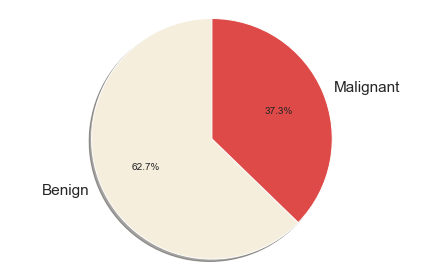

In [329]:
def percent_of_cancer(column, value):
    count=0
    for row in data_codied[column]:
        if row==value:
            count+=1
    existing=count/len(data_codied[column])
    return existing
colors=['#F5EEDC','#DD4A48']
my_data=[percent_of_cancer('diagnosis',0),
        percent_of_cancer('diagnosis',1)]
my_labels='Benign','Malignant'
fig1, ax1=plt.subplots()
ax1.pie(my_data,labels=my_labels,colors=colors,autopct='%1.1f%%',shadow=True, startangle=90)

ax1.axis('equal')
plt.tight_layout()
plt.show()

Z wykresu kołowego widać, że w przedstawionych danych 37,3% pacjętów ma guzy rakowe i 62,7% ich nie ma.

Chcę zweryfikować, ktore dane wpływają najbardziej na diagnozę. W tym celu zobaczę, jak wygląda macierz korelacji, w której korelacja jest od -1 do 1.

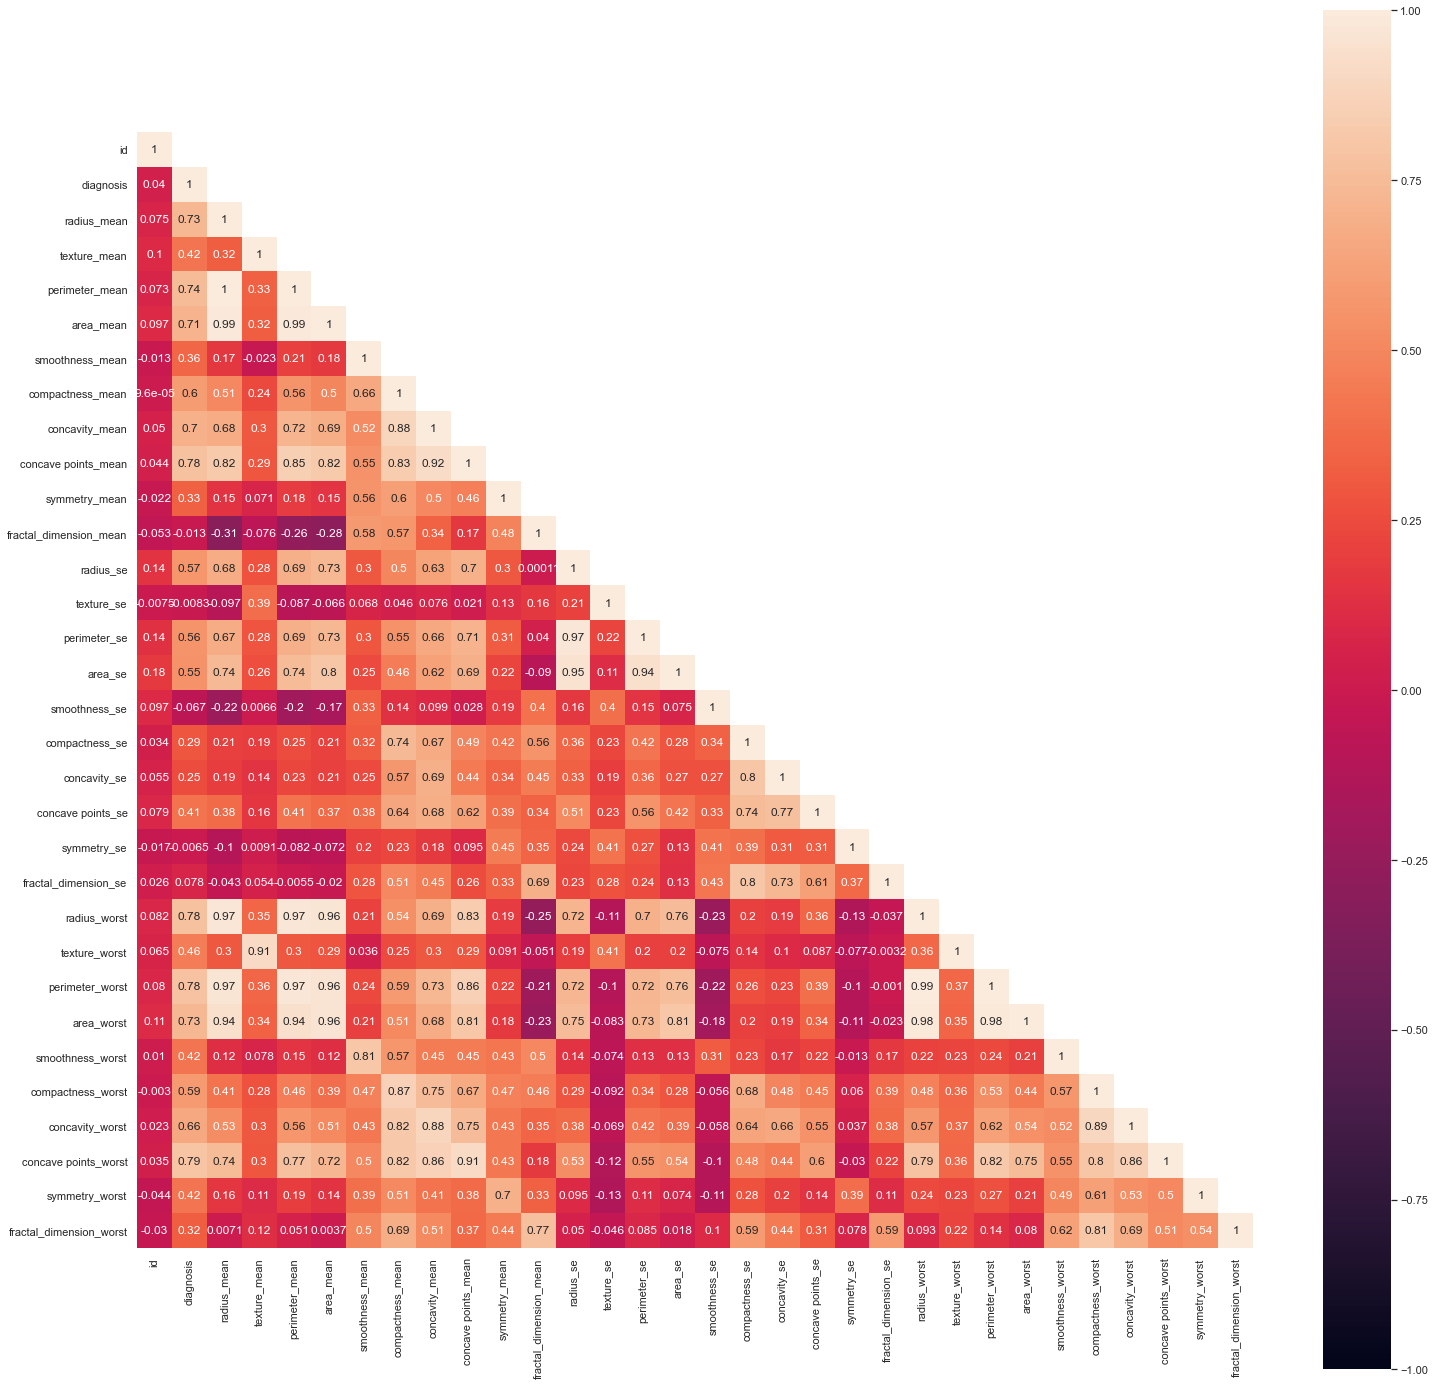

In [330]:
sns.set(style='white')
plt.figure(figsize=(25,25))
mask = np.triu(data_codied.corr(), 1)
dataplot=sns.heatmap(data_codied.corr(),mask=mask,vmax=1, vmin=-1, square=True, annot=True)
plt.show()

Żeby lepiej zobaczyć, co bardziej wpływa na diganozę popatrzę na wykres korelacji konkretnie dla tej zmiennej.

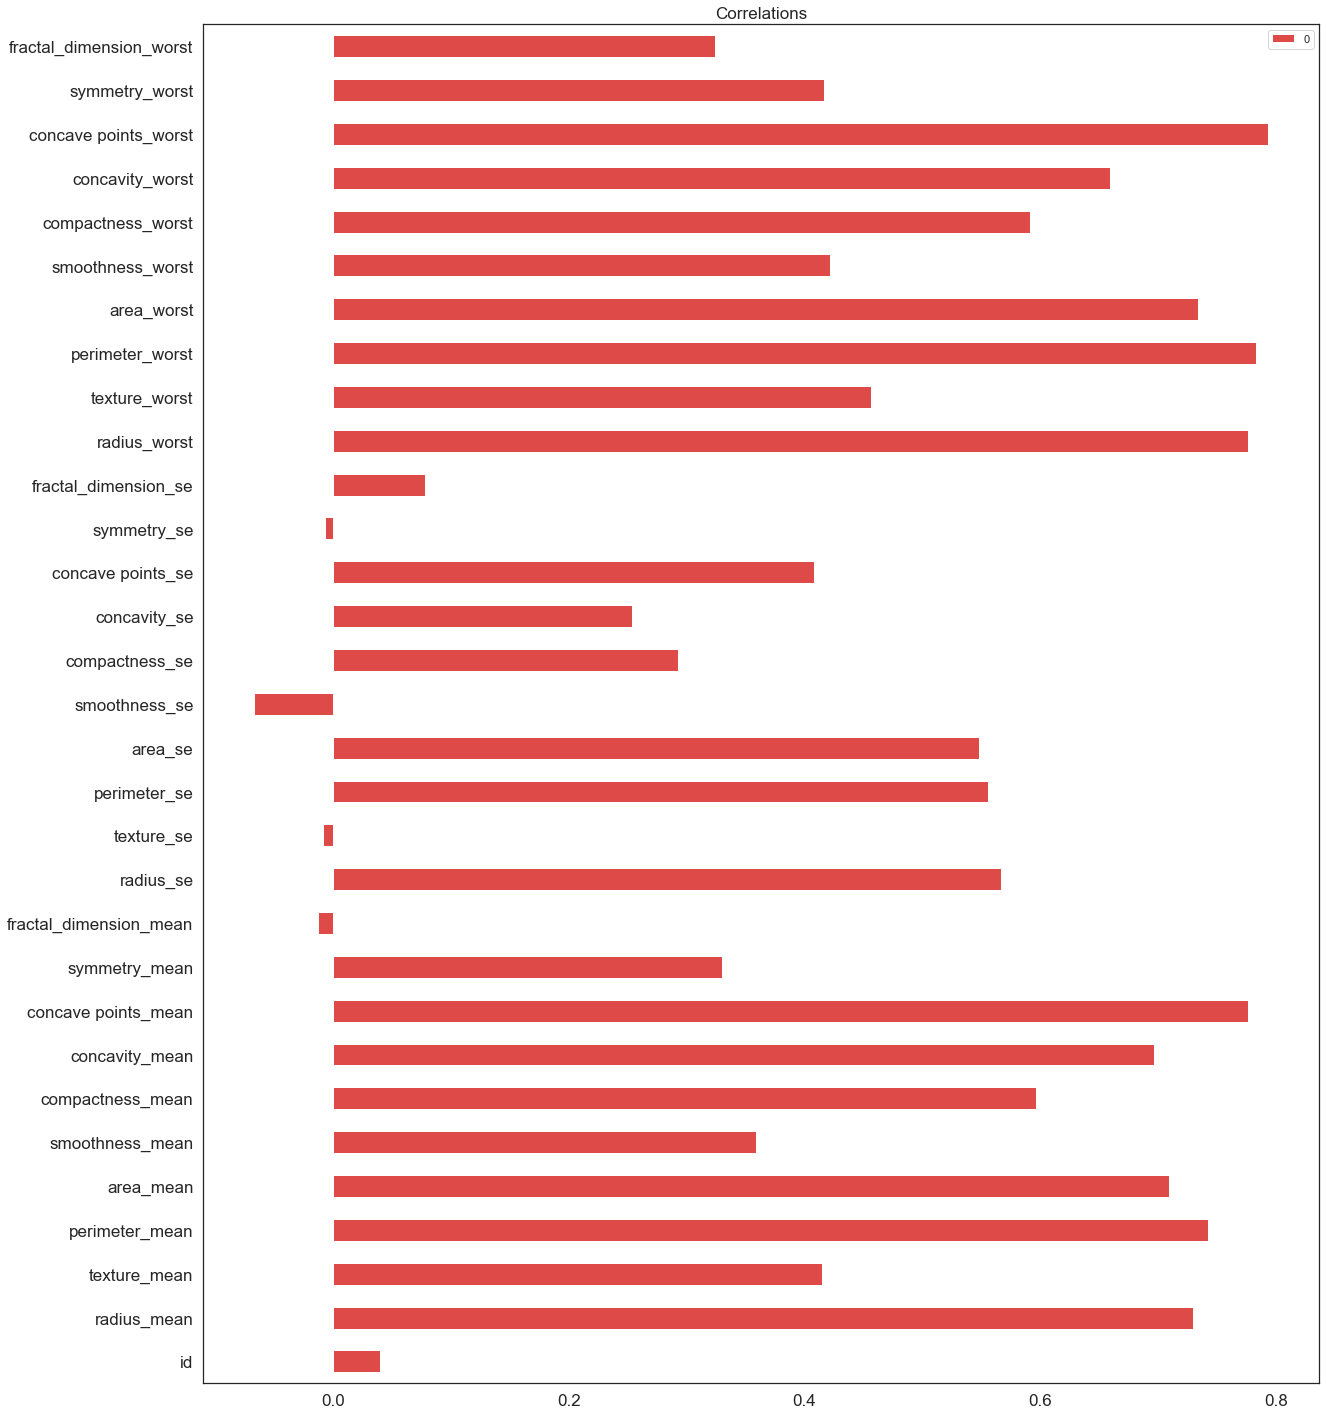

In [331]:
correlation=pd.DataFrame(data_codied.corrwith(data_codied['diagnosis']))

correlation=correlation.drop(["diagnosis"], axis=0)
correlation.plot.barh(
        figsize = (20, 25), 
        fontsize = 17, 
        color = '#DD4A48')
plt.title("Correlations",fontsize=17)
plt.show()

Z tego wykresu wynika, że prawie wszystkie dane są mocno skorelowane z diagnozą, ale nie mogę mieć w modelu danych, które są między sobą bardzo skorelowane. Dlatego stosuję macierz korelacji, żeby zobaczyć gdzie korelacje między danymi są prawie 1. Ale też zwracam uwagę na sensowność tych korelacji, bo na przykład promień wpływa na obwód i pole. No i wychodzi, że kolumny, które zawierają takie skorelowane między sobą to:

* perimeter_mean


* area_mean


* radius_worst


* perimeter_worst


* area_worst


* concave points_mean


* perimeter_se


* area_se

Zanim zobaczę jak wygląda korelacja bez tych wartości, chcę zobaczyć jak się reprezentują te dane na wykresie punktowym i czy da się ustalić między nymi jakąś konkretną zależność.

Text(0.5, 1.0, 'Korelacja pomiędzy radius_mean i perimeter_worst')

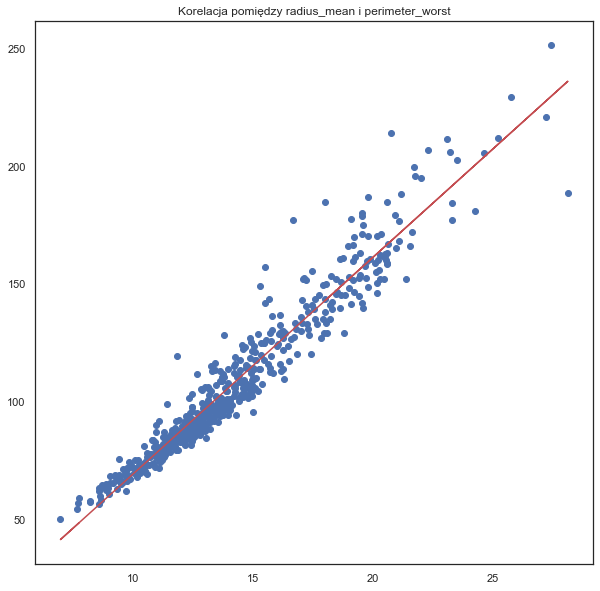

In [332]:
x=data_codied['radius_mean']
y=data_codied['perimeter_worst']
a, b =np.polyfit(x,y,1)
plt.figure(figsize=(10,10))
plt.scatter(x,y)
plt.plot(x, a*x+b, 'r-')
plt.title("Korelacja pomiędzy radius_mean i perimeter_worst")

Współczynnik korelacji pomiędzy tymi zmiennymi wynosi 0,97 (widać z macierzy korelacji). Z wykresu widać,że te dane ładnie się układają wzdłuż prostej. Żeby to było bardziej widoczne, to jeszcze narysowałam tą prostą. Więc, mogę stwierdzić, że zależność pomiędzy tymi danymi jest liniowa.

Zobaczę jak będzie wyglądała korelcja bez tych wartości

Usuwamy dane

In [333]:
#Usuwamy dane
data_codied_1=pd.DataFrame(data_codied.copy())
data_codied_1=data_codied_1.drop(['perimeter_mean','area_mean','radius_worst','perimeter_worst','area_worst','concave points_mean','perimeter_se','area_se','compactness_worst','concave points_worst','concavity_worst'], axis=1)
data_codied_1.tail()

,id,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,radius_se,...,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,texture_worst,smoothness_worst,symmetry_worst,fractal_dimension_worst
564,926424,1,21.56,22.39,0.11100,0.11590,0.24390,0.1726,0.05623,1.1760,...,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,26.40,0.14100,0.2060,0.07115
565,926682,1,20.13,28.25,0.09780,0.10340,0.14400,0.1752,0.05533,0.7655,...,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,38.25,0.11660,0.2572,0.06637
566,926954,1,16.60,28.08,0.08455,0.10230,0.09251,0.1590,0.05648,0.4564,...,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,34.12,0.11390,0.2218,0.07820
567,927241,1,20.60,29.33,0.11780,0.27700,0.35140,0.2397,0.07016,0.7260,...,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,39.42,0.16500,0.4087,0.12400
568,92751,0,7.76,24.54,0.05263,0.04362,0.00000,0.1587,0.05884,0.3857,...,0.007189,0.00466,0.00000,0.00000,0.02676,0.002783,30.37,0.08996,0.2871,0.07039


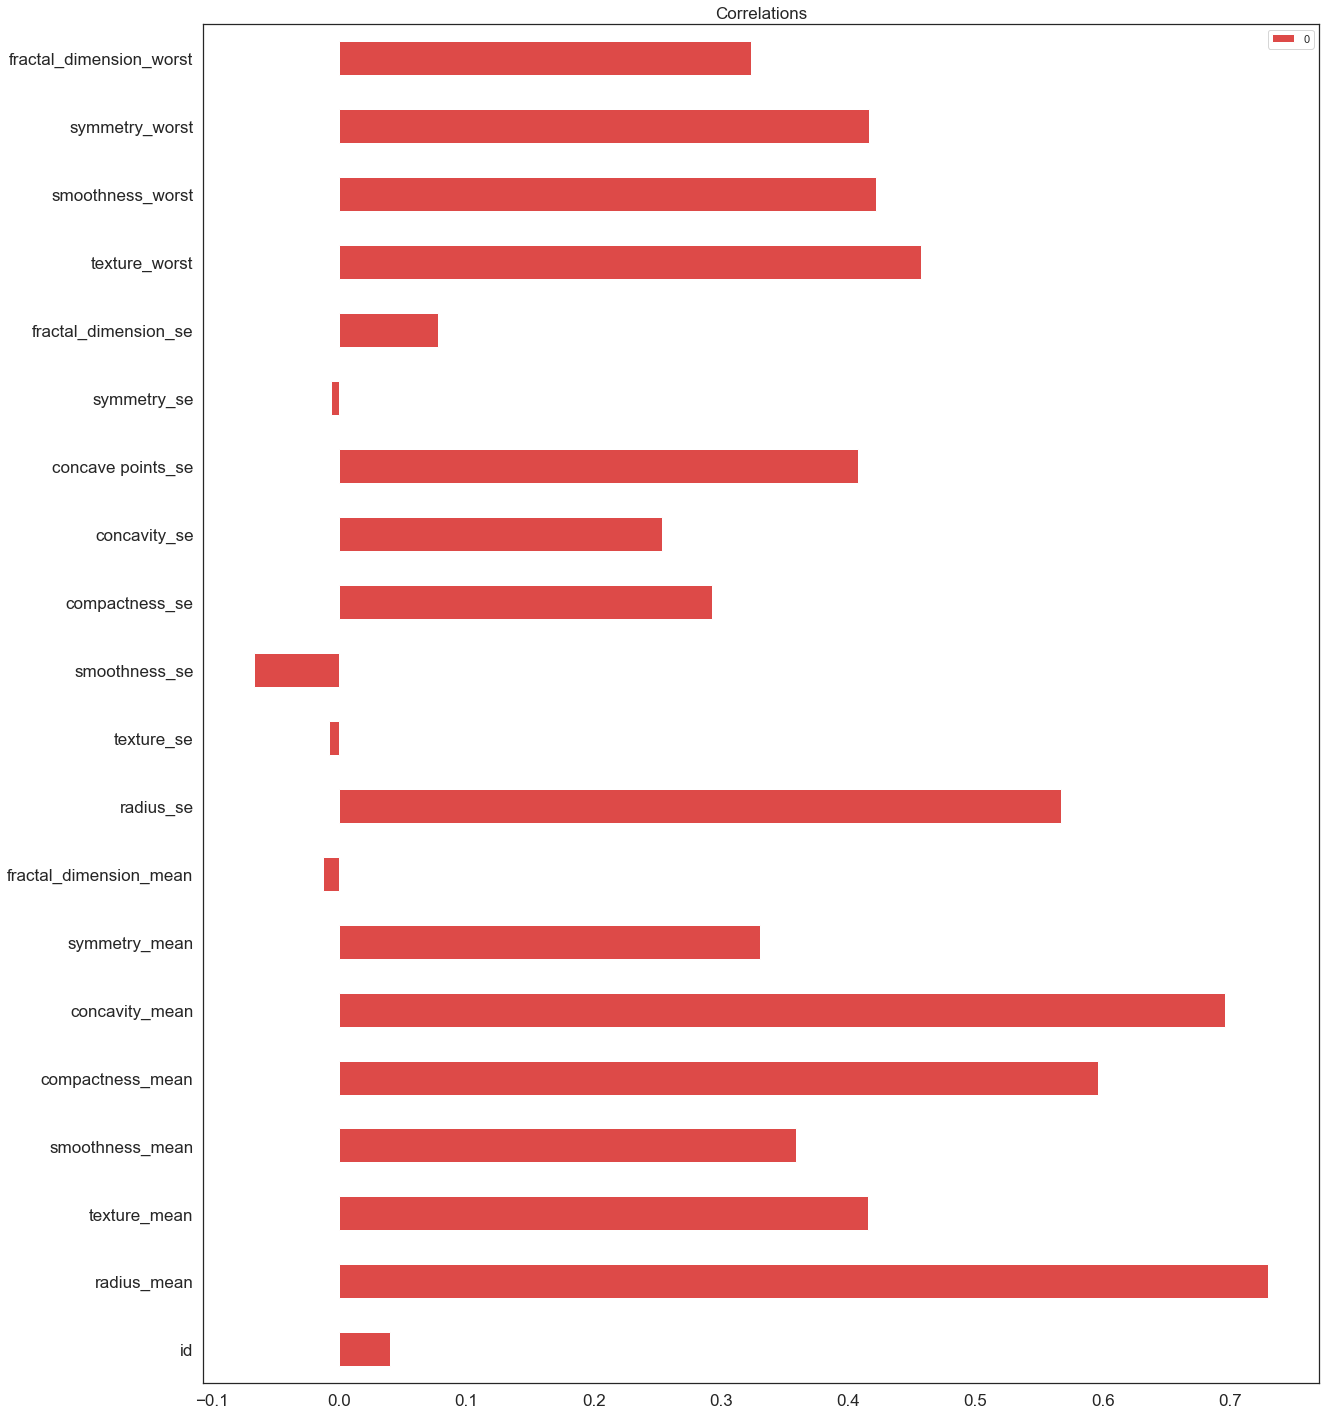

In [334]:
correlation_1=pd.DataFrame(data_codied_1.corrwith(data_codied_1['diagnosis']))

correlation_1=correlation_1.drop(["diagnosis"], axis=0)
correlation_1.plot.barh(
        figsize = (20, 25), 
        fontsize = 17, 
        color = '#DD4A48')
plt.title("Correlations",fontsize=17)
plt.show()

 * To oszacowanie ułatwia mi proces analizy, bo zmniejsza ilość czynników, które wpływają na diagnozę.


 * Z wykresu korelacji widać, że największy wpływ na diagnozę ma **promień guza**. Z korelacją trzeba uważać, czy ta konkretna zmienna w rzeczywistości wpływa w taki sposób. Akurat w tym przypadku ten wpływ jest sensowny.


*  **Dodatnia korelacja** pokazuje wpływ wprost na prawdopodobieństwo odniesienia sukcesu. W przypadku tego zestawu danych im większy będzie promień guza tym większa szansa, że jednak ten guz będzie rakowy.

Zobaczymy jaki ma rozkład ta zmienna radius_mean, czyli średnia promieni guzów

Rysujemy histogram ze krzywą gęstości, prostą średniej i mediany

Skośność wynosi: 0.94 


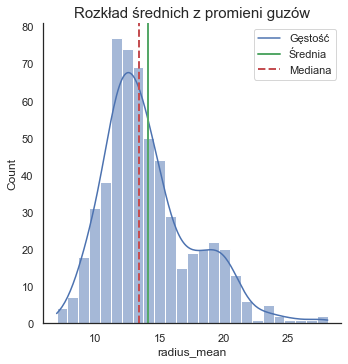

In [335]:
#Rysujemy histogram ze krzywą gęstości, prostą średniej i mediany
density=sns.displot(data_codied['radius_mean'], kde=True, bins=25)
plt.axvline(data_codied['radius_mean'].mean(), color='g', linewidth=2)
plt.axvline(data_codied['radius_mean'].median(), color='r', linestyle='dashed', linewidth=2)
plt.legend({'Gęstość':density,'Średnia':np.array(data_codied['radius_mean']).mean(),'Mediana':np.median(data_codied['radius_mean'])})
plt.title("Rozkład średnich z promieni guzów", fontsize=15)
print("Skośność wynosi: {:.2f} ".format(skew(data_codied['radius_mean'])))

Patrząc na ten histogram mogę stwierdzić, że jest prawoskośny o skośności **0.94** i jest dwumodalny.


Ale chcę jeszcze zobaczyć jaki rozkład ma ta zmienna w zależności od diagnozy.

In [336]:
#Filtrujemy dane według zmiennej diagnosis
radius_0=data_codied[data_codied['diagnosis']==0]
radius_1=data_codied[data_codied['diagnosis']==1]

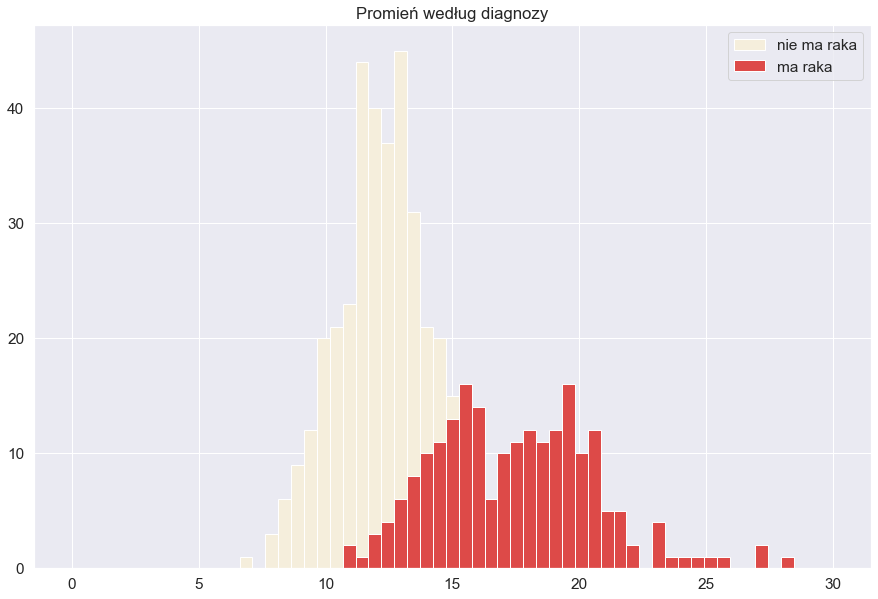

In [359]:
plt.figure(figsize=(15,10))
bins=np.linspace(0,30,60)
plt.hist(radius_0['radius_mean'], bins, label='nie ma raka', color='#F5EEDC')
plt.hist(radius_1['radius_mean'], bins, label='ma raka', color='#DD4A48')
plt.title("Promień według diagnozy")
plt.legend(loc='upper right')
plt.show()

A to wygląda ciekawie. Wyżej pisałam,że wykres jest dwumodalny, ale z tego wykresu widać, że chorzy na raka będą mieć średnią z promieni guzów z drugiego garba.

Chcę narysować wykresy gęstości tych dwóch zmiennych i jak one się pokrywają.

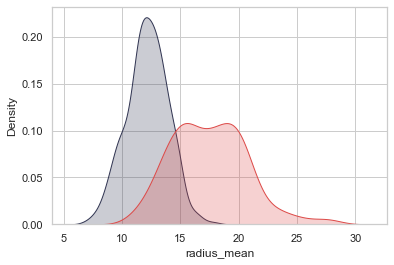

In [360]:
sns.set(style="whitegrid")
fig=sns.kdeplot(radius_0['radius_mean'],shade=True, color='#313552')
#Zastosuję tu inny ciemniejszy kolor,żeby było widać
fig=sns.kdeplot(radius_1['radius_mean'], shade=True, color='#DD4A48')
plt.show()

Za pomocą wykresów gęstości można zobaczyć, że te obszary pod wykresami się przecinają.

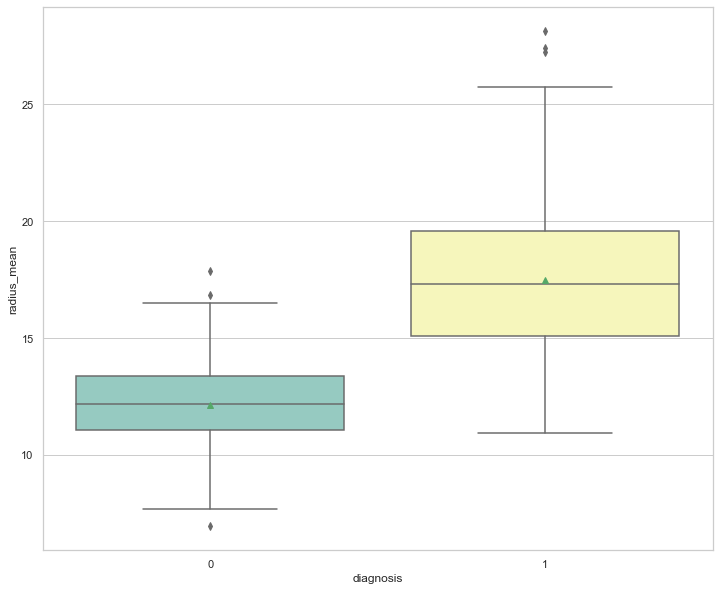

In [339]:
plt.figure(figsize=(12,10))
sns.set_style("whitegrid")
sns.boxplot(x='diagnosis',y='radius_mean', data=data_codied, showmeans=True, palette='Set3')
plt.show()

Z wykresu pudełkowego widać, że większe promienie mają guzy rakowe i to najwyraźniej pokazuje wysokość zółtego pudełka. Także z takiego typu wykresu ładnie widać wartości odstajające. Na szczęście w tym zestawie danych mamy bardzo mało takich obserwacji i za pomocą StandartScaler() uda się rozwiązać ten problem.

Spróbuję rozdzielić te dane na klastry.

Tu stosuję StandartScaler i rozwiązuję problem wartości odstających.

In [362]:
#Tu stosuję StandartScaler i rozwiązuję problem wartości odstających.
scaler=StandardScaler()
data_std=scaler.fit_transform(data_codied)

Zaczynam proces rozdzielenia na klasrty. Ale najpierw trzeba wyznaczyć ilość klastrów. Zastosuję dwie metody na to : wykres hierarchiczny i metodę łokcia. Ilości klastrów z tych dwóch metod muszą być sobie równe.

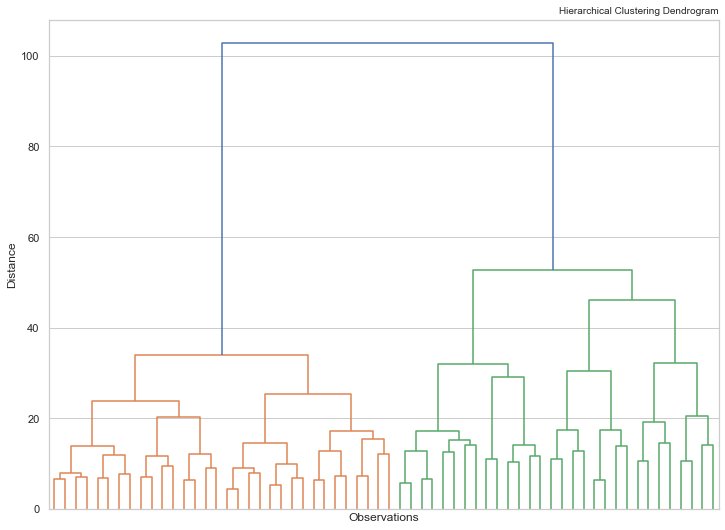

In [341]:
hier_clust = linkage(data_std, metric = "euclidean", method = "ward")
plt.figure(figsize= (12, 9))
plt.title("Hierarchical Clustering Dendrogram", fontsize=10, loc='right')
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hier_clust, truncate_mode = "level", p = 5, show_leaf_counts = False, no_labels = True)
plt.show()

Stosuję wykres hierarchiczny, za pomocą którego wyznaczam ilość klastrów. Na tym wykresie widać, że najlepsza ilość to k=2.

Zastosuję metodę łokcia, zakładając, że nie wiem ile klastórw warto zastosować. Stosuję metodę k-średnich.

In [342]:
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(data_std)
    wcss.append(kmeans.inertia_)

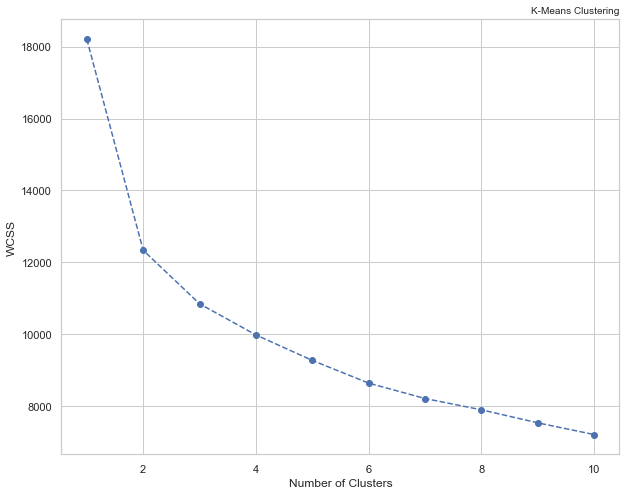

In [343]:
plt.figure(figsize = (10,8))
plt.plot(range(1,11), wcss, marker = "o", linestyle = "--")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("K-Means Clustering", fontsize=10, loc='right')
plt.show()

Z wykresu też widać,że ten moment "przełomowy" następuje przy rozdzieleniu na 2 klastry. I w sumie to logiczne, bo mamy albo diagnozę pozytywną albo negatywną.

In [344]:
kmeans = KMeans(n_clusters=2, init="k-means++", random_state=42)
kmeans.fit(data_std)

KMeans(n_clusters=2, random_state=42)

In [345]:
data_km=data_codied.copy()
data_km["Segment K-means"]=kmeans.labels_
data_km_analisys = data_km.groupby(["Segment K-means"]).mean()
data_km_analisys

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
Segment K-means,,,,,,,,,,,,,,,,,,,,,
0,2.550852e+07,0.086162,12.379110,18.222245,79.564752,482.549347,0.092436,0.078831,0.044714,0.026654,...,13.709971,24.052324,89.144256,590.141514,0.125683,0.183033,0.167083,0.077480,0.271328,0.078834
1,4.038606e+07,0.962366,17.727043,21.487581,117.511183,1009.760753,0.104440,0.156869,0.179576,0.094767,...,21.538978,29.023118,144.566559,1478.643011,0.146136,0.400942,0.488615,0.191053,0.328679,0.094471


No i widzimy tu, że w jednym klastrze będzie zawarta informacja na temat pacjenta bez raka. Natomiast w drugim będzie informacja o chorym na raka pacjencie.

In [346]:
data_km_analisys["#_obs"] = data_km[["Segment K-means","radius_mean"]].groupby(["Segment K-means"]).count()

data_km_analisys["%_obs"] = data_km_analisys["#_obs"] / data_km_analisys["#_obs"].sum() * 100


data_km_analisys

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,#_obs,%_obs
Segment K-means,,,,,,,,,,,,,,,,,,,,,
0,2.550852e+07,0.086162,12.379110,18.222245,79.564752,482.549347,0.092436,0.078831,0.044714,0.026654,...,89.144256,590.141514,0.125683,0.183033,0.167083,0.077480,0.271328,0.078834,383,67.311072
1,4.038606e+07,0.962366,17.727043,21.487581,117.511183,1009.760753,0.104440,0.156869,0.179576,0.094767,...,144.566559,1478.643011,0.146136,0.400942,0.488615,0.191053,0.328679,0.094471,186,32.688928


Kod powyżej oblicza ilość obserwacji znajdujących się w pierwszym lub w drugim klastrze i procentowo wielkość klastrów.

C:\Users\julka\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


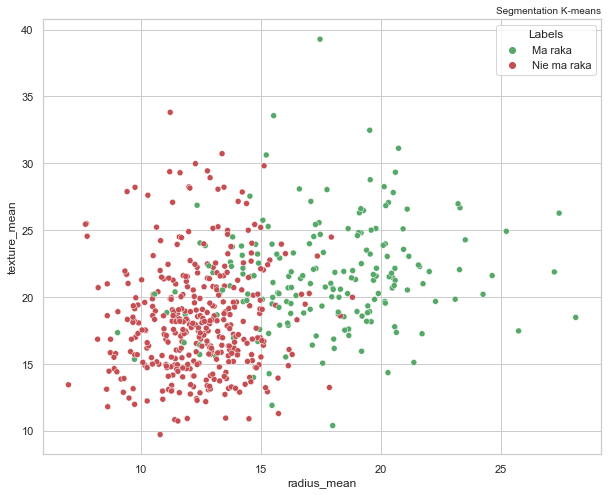

In [347]:
data_km["Labels"] = data_km["Segment K-means"].map({0:"Nie ma raka",
                                                1:"Ma raka"})
x_axis = data_km["radius_mean"]
y_axis = data_km["texture_mean"]
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = data_km["Labels"], palette = ["g", "r"])
plt.title("Segmentation K-means", fontsize=10, loc='right')
plt.show()

Na wykresie jest przedstawione rozdzielenie na klastry według tekstury i promienia guza.
Następnie robię rozdzielenie na próbę uczącą i testową i zapisuję indeksy.


Rozdzielenie jest widoczne, ale te klastry trochę nachodzą na siebie nawzajem. Na czerwono jest pokazany klaster, w którym się znajdują pacjenci, którzy mają raka, a w klastrze na zielono znajdują się pacjenci, którzy nie mają raka.


In [356]:
X=data_codied.drop(['diagnosis'], axis=1)
y=data_codied['diagnosis']

x_train, x_test, y_train, y_test=train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

test_id=x_test['id']
x_test=x_test.drop(['id'], axis=1)

train_id=x_train['id']
x_train=x_train.drop(['id'],axis=1)
print("Number transactions x_train dataset: ", x_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions x_test dataset: ",x_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions x_train dataset:  (455, 30)
Number transactions y_train dataset:  (455,)
Number transactions x_test dataset:  (114, 30)
Number transactions y_test dataset:  (114,)


Wyświetliłam ile obserwacji się znajduje w każdej z prób.

Będę stosowała lasy losowe w celu budowania modelu na przewidywania, który z pacjętów będzie miał raka, a który nie. Dlatego chcę znaleźć ile lasów będzie najlepiej zrobić. Rysując wykres mogę wyznaczyć ilość lasów czyli n_estimators.

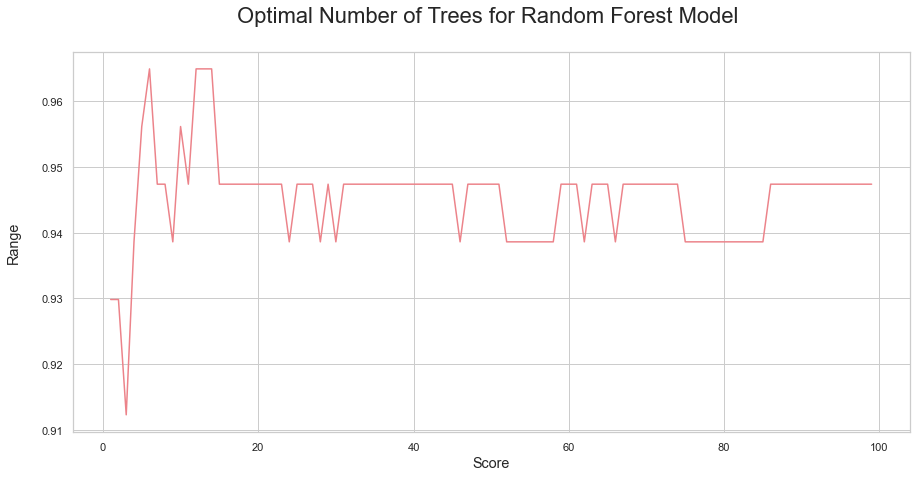

In [350]:
score_array = []
for each in range(1,100):
    rf_loop = RandomForestClassifier(n_estimators = each, random_state = 1) 
    rf_loop.fit(x_train,y_train)
    score_array.append(rf_loop.score(x_test,y_test))
 

fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,100),score_array, color = '#ec838a')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

Patrząc na wykres uważam, że n_estimaetors, czyli tych drzew lepiej zrobić 6, bo wtedy kreska wykresu znajduje się maksymalnie wysoko.

In [351]:
classifier = RandomForestClassifier(n_estimators = 6, 
criterion = 'entropy', random_state = 0)
classifier.fit(x_train, y_train)
y_pred=classifier.predict(x_test)
print('Accuracy of Random Forest Classifier in test set: {:.2f}'.format(classifier.score(x_test, y_test)))

Accuracy of Random Forest Classifier in test set: 0.96


Precyzyjność modelu wynosi 96%. Ale chcę spojrzeć na macierz błędu.

Text(0.5, 12.5, 'Predicted label\n')

<Figure size 2016x1440 with 0 Axes>

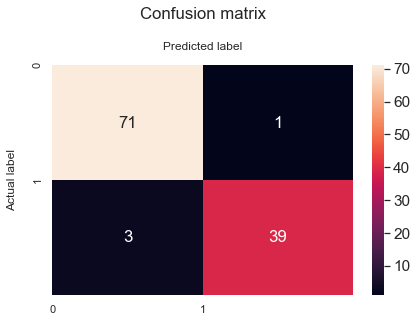

In [352]:
cm = confusion_matrix(y_test, y_pred) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))


fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

Ta macierz się nazywa confusion matrix czyli macierz błędu. Z jej pomocą można wyznaczyć ile model zrobił dobrych predykcji, a ile źle.
* 71- to mamy prawdziwy pozytywnych
* 39-prawdziwo negatywny
* 1-fałszywe pozytywne
* 3-fałszywe negatywne

Trzeba zwrócić uwagę na fałszywe negatywnych, bo zwłaszcza na danych medycznych może bardzo wpływać na zdrowie ludzi, bo te predykcje, które wychodzą na fałszywe negatywne nie wykrywają prawdziwych przypadków, czyli w przypadku danych model nie wykryje, że pacjent ma raka.


In [353]:
y_pred_probs = classifier.predict_proba(x_test)
y_pred_probs  = y_pred_probs [:, 1]

W tym momencie przydały się indeksy, bo dodaję kolumnę z indeksami do wyników, żeby było widać dla którego klienta są diagnozy i predykcje

In [365]:
final_results = pd.concat([test_id,y_test], axis = 1).dropna()
final_results['predictions'] = y_pred
final_results["probability_to_have_cancer"] = y_pred_probs
final_results["probability_to_have_cancer"] = final_results["probability_to_have_cancer"]*100
final_results["probability_to_have_cancer"]=final_results["probability_to_have_cancer"].round(2)
final_results = final_results[['id', 'diagnosis', 'predictions', 'probability_to_have_cancer']]

final_results.to_csv('Czy_ma_raka.csv')
final_results

,id,diagnosis,predictions,probability_to_have_cancer
477,911673,0,0,0.00
558,925277,0,0,33.33
537,919812,0,0,33.33
322,894855,0,0,0.00
474,911391,0,0,0.00
...,...,...,...,...
364,9010877,0,0,0.00
518,917062,0,0,0.00
354,901011,0,0,0.00
23,851509,1,1,100.00


Jak widać mam wyniki i prawdopodobieństwa. 0-nie ma raka, 1-ma raka.

### Wyniki pracy

* Spojrzałam na rozkłady zmiennych
* Za pomocą wyznaczenia korelacji spojrzałam jak wpływają poszczególne zmienne na cel predykcji i jak są skorelowane między sobą
* Przeprowadzono rozdzielenie na klastry
* Zastosowane zostały lasy losowe z wyznaczeniem prawdopodobieństwa na pozytywną diagnozę
* Wynik jest zapisasny w postaci pliku csv